In [54]:
import pandas as pd
from collections import Counter
import networkx as nx
import re
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
import numpy as np
from cdlib import algorithms
import random
from collections import defaultdict, Counter
import community.community_louvain as community
from tqdm import tqdm


Open Dataset

In [55]:
df = pd.read_csv('covid19_tweets.csv')
df = df.drop_duplicates(subset=['text'])
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [56]:
save_path = 'data/covid19_tweets_df.pkl'

df.to_pickle(save_path)
print(f"{save_path}")

data/covid19_tweets_df.pkl


In [57]:
#date to datetype
df['date'] = pd.to_datetime(df['date'])

df['year_month_day'] = df['date'].dt.to_period('D')  # Year-Month-Day for daily tracking
# sorting
df = df.sort_values(by='date')

# Clean the hashtags: convert to a clean list
df['hashtags_cleaned'] = (
    df['hashtags']
    .str.replace(r"[^\w\s,#]", "", regex=True)  # Remove special characters ([, ], ', etc.)
    .str.replace("No Hashtag", "", regex=False)  # Remove unnecessary default values
)

# Extract unique hashtags
hashtags = df['hashtags_cleaned'].dropna().str.split(",").explode().str.strip().str.lower()
# Filter out empty hashtags after cleaning
hashtags_filtered = hashtags[hashtags != '']

df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,year_month_day,hashtags_cleaned
17175,Jessica Luther Rummel,"Denton, Texas",Mother. Partner. Scholar. Activist. Alchemist....,2020-07-05 03:28:16,234,28,220,False,2020-07-24 23:47:08,PROTESTORS NEEDED 6PM-10PM DAILY (NOW). 1450 E...,NaN,Twitter Web App,False,2020-07-24,NaN
17174,Dr. Lipi #TrustDrFauci Roy,"New York, USA",@NBCNews @MSNBC @Forbes Medical Contributor | ...,2009-10-11 18:46:51,12485,4603,38120,True,2020-07-24 23:47:12,Always honored to speak w @NicolleDWallace abo...,['covid19'],Twitter Web App,False,2020-07-24,covid19
17173,Patty Hayes,"Seattle, WA",Director of Public Health - Seattle & King Cou...,2017-07-07 18:56:50,718,162,2276,False,2020-07-24 23:47:12,"Excellent partnership to prevent #COVID19, tha...",['COVID19'],Twitter for Android,False,2020-07-24,COVID19
17172,Clive Gorman,"Victoria, British Columbia",Marketing Director @CNEGames for @idlechampion...,2011-12-23 02:02:35,597,224,23824,False,2020-07-24 23:47:12,Don't take your eye off the ball. There are st...,['COVID19'],Twitter for Android,False,2020-07-24,COVID19
17171,Tristyn Russelo,"Alberta, Canada",NaN,2017-06-14 22:01:54,5,68,57,False,2020-07-24 23:47:13,"Apparently, at the Timberlea @saveonfoods stor...",NaN,Twitter Web App,False,2020-07-24,NaN


In [58]:
cutoff_index = int(len(df) * 0.3)  # 90% of the dataset

cutoff_date = df.iloc[cutoff_index]['date']
print("Cutoff date for 90% of tweets:", cutoff_date)

df_train = df[df['date'] <= cutoff_date]  # first 90% of tweets
df_test = df[df['date'] > cutoff_date]  # last 10% for testing

Cutoff date for 90% of tweets: 2020-08-01 16:28:01


In [59]:
import networkx as nx
import re

# Create an undirected graph
G = nx.Graph()

# Extract mentions and build the graph
for _, row in df.iterrows():
    user1 = row['user_name']  # author of the tweet
    mentions = re.findall(r'@(\w+)', row['text'])  # extract mentions

    for user2 in mentions:
        if user1 != user2:  # avoid self-loops
            if not G.has_edge(user1, user2):
                G.add_edge(user1, user2)  # add an unweighted edge only if it doesn't already exist

# Graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 69864
Number of edges: 73941


In [60]:

# Remove isolated nodes (nodes with no edges)
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

print(f"Number of isolated nodes removed: {len(isolated_nodes)}")
print(f"Number of remaining nodes: {G.number_of_nodes()}")

# Extract the Largest Connected Component (LCC)
LCC = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(LCC).copy()

print(f"Number of nodes in the LCC: {G_lcc.number_of_nodes()}")

Number of isolated nodes removed: 0
Number of remaining nodes: 69864
Number of nodes in the LCC: 41062


In [61]:
# Ensure that the DataFrame is sorted by date
df = df.sort_values(by='date')

# Divide the DataFrame into 10 equal parts based on date
df['decile'] = pd.qcut(df['date'], q=10, labels=False)

# Dictionary to store the graphs
graphs = {}

# Create graphs for each decile
for decile in range(10):
    df_decile = df[df['decile'] == decile]

    # Create an undirected graph for this decile
    G_decile = nx.Graph()

    # Extract mentions and construct the graph
    for _, row in df_decile.iterrows():
        user1 = row['user_name']  # tweet author
        mentions = re.findall(r'@(\w+)', row['text'])  # extract mentions

        for user2 in mentions:
            if user1 != user2:  # avoid self-loops
                if not G_decile.has_edge(user1, user2):
                    G_decile.add_edge(user1, user2)  # add an unweighted edge only if it does not already exist

    # Store the graph in the dictionary
    graphs[decile] = G_decile

    # Display graph statistics for this decile
    print(f"Decile {decile + 1}: Number of nodes: {G_decile.number_of_nodes()}, Number of edges: {G_decile.number_of_edges()}")


Decile 1: Number of nodes: 8628, Number of edges: 7251
Decile 2: Number of nodes: 8465, Number of edges: 7255
Decile 3: Number of nodes: 10312, Number of edges: 8553
Decile 4: Number of nodes: 9719, Number of edges: 8471
Decile 5: Number of nodes: 9969, Number of edges: 8111
Decile 6: Number of nodes: 9234, Number of edges: 7480
Decile 7: Number of nodes: 8191, Number of edges: 6525
Decile 8: Number of nodes: 8915, Number of edges: 7734
Decile 9: Number of nodes: 9686, Number of edges: 7896
Decile 10: Number of nodes: 9375, Number of edges: 8217


In [62]:
# Dictionary to store the number of common nodes between graphs
common_nodes_count = {}

# Compare each pair of graphs
for i in range(10):
    for j in range(i + 1, 10):
        # Get the sets of nodes for both graphs
        nodes_i = set(graphs[i].nodes())
        nodes_j = set(graphs[j].nodes())

        # Compute the intersection of the node sets
        common_nodes = nodes_i.intersection(nodes_j)

        # Store the number of common nodes
        common_nodes_count[(i, j)] = len(common_nodes)

        # Display the number of common nodes
        print(f"Common nodes between Decile {i + 1} and Decile {j + 1}: {len(common_nodes)}")

# Display the complete dictionary of common nodes
print("\nTotal number of common nodes between deciles:")
for (i, j), count in common_nodes_count.items():
    print(f"Deciles {i + 1} and {j + 1}: {count} common nodes")


Common nodes between Decile 1 and Decile 2: 1292
Common nodes between Decile 1 and Decile 3: 1123
Common nodes between Decile 1 and Decile 4: 1148
Common nodes between Decile 1 and Decile 5: 1049
Common nodes between Decile 1 and Decile 6: 1059
Common nodes between Decile 1 and Decile 7: 901
Common nodes between Decile 1 and Decile 8: 1044
Common nodes between Decile 1 and Decile 9: 1026
Common nodes between Decile 1 and Decile 10: 1027
Common nodes between Decile 2 and Decile 3: 1201
Common nodes between Decile 2 and Decile 4: 1204
Common nodes between Decile 2 and Decile 5: 981
Common nodes between Decile 2 and Decile 6: 1093
Common nodes between Decile 2 and Decile 7: 887
Common nodes between Decile 2 and Decile 8: 1190
Common nodes between Decile 2 and Decile 9: 1083
Common nodes between Decile 2 and Decile 10: 1098
Common nodes between Decile 3 and Decile 4: 1448
Common nodes between Decile 3 and Decile 5: 1225
Common nodes between Decile 3 and Decile 6: 1157
Common nodes between 

In [63]:
import matplotlib.pyplot as plt
from collections import defaultdict
from cdlib import algorithms

# Dictionary to store community partitions for each decile
community_partitions = {}

# Apply the Louvain algorithm for each decile
for decile in range(10):
    G_decile = graphs[decile]
    louvain = algorithms.louvain(G_decile)
    communities = louvain.communities
    community_dict = {node: com_id for com_id, community in enumerate(communities) for node in community}
    community_partitions[decile] = community_dict

    # Display the number of communities for this decile
    num_communities = len(communities)
    print(f"Decile {decile + 1}: Number of communities = {num_communities}")


Decile 1: Number of communities = 1951
Decile 2: Number of communities = 1847
Decile 3: Number of communities = 2460
Decile 4: Number of communities = 2059
Decile 5: Number of communities = 2436
Decile 6: Number of communities = 2262
Decile 7: Number of communities = 2140
Decile 8: Number of communities = 1891
Decile 9: Number of communities = 2373
Decile 10: Number of communities = 1927


In [64]:
def get_community_members(partition_dict):
    """
    Convert a partition dictionary {node: community_id} to {community_id: set(nodes)}
    """
    communities = {}
    for node, com_id in partition_dict.items():
        if com_id not in communities:
            communities[com_id] = set()
        communities[com_id].add(node)
    return communities

def calculate_jaccard_similarity(community1, community2):
    """Calculate Jaccard similarity between two sets of nodes."""
    intersection = len(community1 & community2)
    union = len(community1 | community2)
    return intersection / union if union > 0 else 0

def match_communities(communities_i, communities_i_plus_1):
    """
    Match communities between consecutive deciles using a greedy approach based on Jaccard similarity.

    Args:
        communities_i: Dict of community_id -> set of nodes from decile i
        communities_i_plus_1: Dict of community_id -> set of nodes from decile i+1

    Returns:
        List of tuples (community_id_i, community_id_i_plus_1, similarity)
    """
    # Calculate all pairwise similarities
    similarities = []
    for com_id1, nodes1 in communities_i.items():
        for com_id2, nodes2 in communities_i_plus_1.items():
            sim = calculate_jaccard_similarity(nodes1, nodes2)
            if sim > 0:  # Only consider non-zero similarities
                similarities.append((com_id1, com_id2, sim))

    # Sort by similarity in descending order
    similarities.sort(key=lambda x: x[2], reverse=True)

    # Keep track of matched communities
    matched_i = set()
    matched_i_plus_1 = set()
    matches = []

    # Greedy matching
    for id1, id2, sim in similarities:
        if id1 not in matched_i and id2 not in matched_i_plus_1:
            matches.append((id1, id2, sim))
            matched_i.add(id1)
            matched_i_plus_1.add(id2)

    return matches

def track_communities_evolution(community_partitions):
    """
    Track the evolution of communities across all deciles.

    Args:
        community_partitions: Dict of decile -> {node: community_id}

    Returns:
        List of matches for each consecutive pair of deciles
    """
    all_matches = []

    for decile in range(len(community_partitions) - 1):
        # Convert partition dictionaries to community membership dictionaries
        communities_i = get_community_members(community_partitions[decile])
        communities_i_plus_1 = get_community_members(community_partitions[decile + 1])

        matches = match_communities(communities_i, communities_i_plus_1)
        all_matches.append({
            'decile_pair': (decile, decile + 1),
            'matches': matches
        })

        print(f"\nMatching between deciles {decile} and {decile + 1}:")
        print(f"Number of matches found: {len(matches)}")
        print(f"Average similarity: {sum(m[2] for m in matches) / len(matches) if matches else 0:.3f}")

    return all_matches



In [65]:
evolution = track_communities_evolution(community_partitions)


Matching between deciles 0 and 1:
Number of matches found: 334
Average similarity: 0.241

Matching between deciles 1 and 2:
Number of matches found: 304
Average similarity: 0.212

Matching between deciles 2 and 3:
Number of matches found: 379
Average similarity: 0.236

Matching between deciles 3 and 4:
Number of matches found: 324
Average similarity: 0.220

Matching between deciles 4 and 5:
Number of matches found: 374
Average similarity: 0.259

Matching between deciles 5 and 6:
Number of matches found: 358
Average similarity: 0.279

Matching between deciles 6 and 7:
Number of matches found: 309
Average similarity: 0.237

Matching between deciles 7 and 8:
Number of matches found: 324
Average similarity: 0.234

Matching between deciles 8 and 9:
Number of matches found: 319
Average similarity: 0.230


In [66]:
def visualize_similarity_evolution(all_matches):
    """
    Visualize the evolution of average similarity between consecutive deciles.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Create figure
    plt.figure(figsize=(10, 6))

    # Prepare data
    deciles = [f"{m['decile_pair'][0]}-{m['decile_pair'][1]}" for m in all_matches]
    avg_similarities = [np.mean([match[2] for match in m['matches']]) for m in all_matches]

    # Plot
    plt.plot(range(len(deciles)), avg_similarities, 'bo-', linewidth=2)
    plt.title('Evolution of Average Jaccard Similarity Between Consecutive Deciles')
    plt.xlabel('Decile Transitions')
    plt.ylabel('Average Similarity')
    plt.xticks(range(len(deciles)), deciles, rotation=45)
    plt.grid(True)

    # Add some spacing to prevent label cutoff
    plt.tight_layout()
    plt.show()

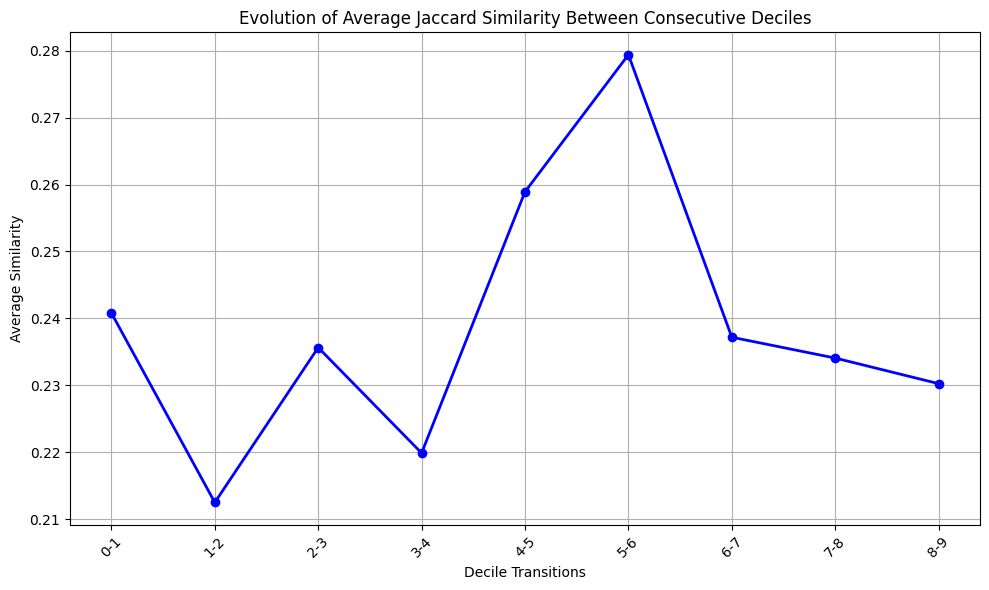

In [67]:
visualize_similarity_evolution(evolution)

In [68]:
import networkx as nx
from collections import Counter

# Detection of triangles (triadic closure)
triangles = [tuple(sorted(tri)) for tri in nx.enumerate_all_cliques(G) if len(tri) == 3]
triangle_count = len(triangles)
print(f"Number of detected triangles: {triangle_count}")

# Detection of recurring motifs
motifs = Counter()

for node in G.nodes():
    neighbors = list(G.neighbors(node))
    degree = len(neighbors)

    if degree >= 2:
        # Star motif (a node connected to multiple others)
        motifs["star"] += 1

    if degree == 2:
        # Chain motif (A → B → C)
        motifs["chain"] += 1

# Display of dominant motifs
print("Recurring mention motifs:")
for motif, count in motifs.items():
    print(f"{motif} : {count}")


Number of detected triangles: 43
Recurring mention motifs:
star : 21512
chain : 10294


The low number of triangles (43 for 70,000 nodes and 74,000 edges) suggests a weakly clustered network, where mentions follow a **broadcast** logic rather than the formation of interconnected groups. This may reflect a star structure with influencers widely mentioned without interactions between their mentioners, typical of networks like Twitter favoring ephemeral interactions. In parallel, the presence of 10,000 chains involving about 30,000 nodes indicates a **sequential propagation of information**, rather than a closed-loop diffusion. This suggests a **relay** mechanism, characteristic of viral dynamics, where information spreads without direct feedback to its transmitter.


visualization to see distribution of dataset over time

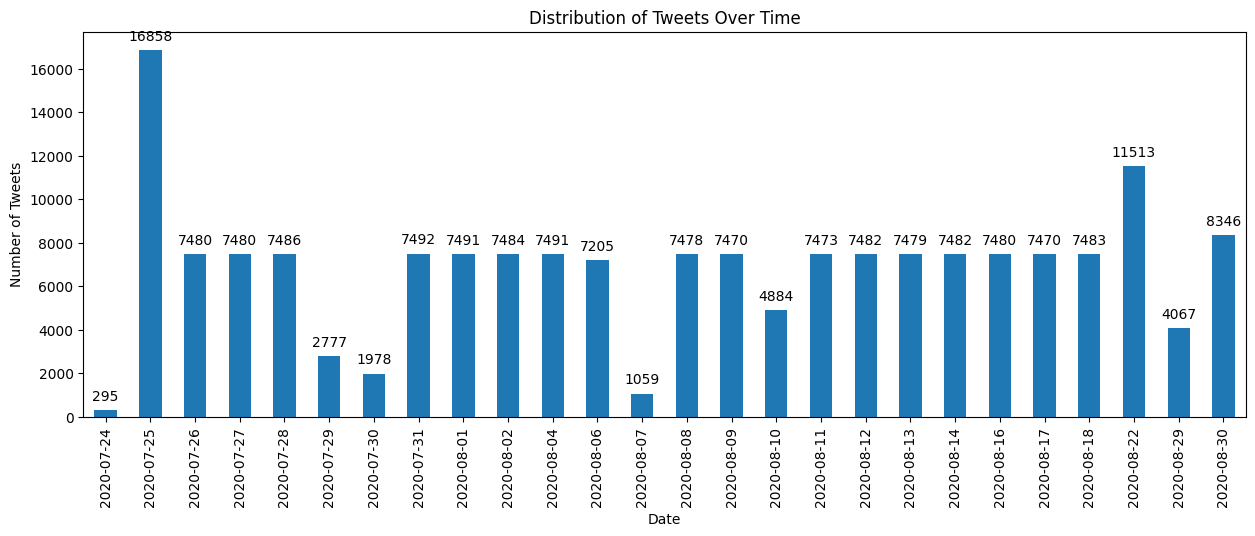

In [69]:
# Plot with labels
ax = df['date'].dt.date.value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

# Add labels to the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweets Over Time")

plt.show()

Assortativity Analysis

In [70]:
# Compute assortativity coefficients
followers_assortativity = nx.numeric_assortativity_coefficient(G_mentions, 'followers')
friends_assortativity = nx.numeric_assortativity_coefficient(G_mentions, 'friends')

print(f"Assortativity for followers count: {followers_assortativity:.4f}")
print(f"Assortativity for friends count: {friends_assortativity:.4f}")
# Create a directed mention graph
G_mentions = nx.DiGraph()

# Iterate through tweets to build the network
for _, row in df.iterrows():
    user1 = row['user_name']
    mentions = re.findall(r'@(\w+)', row['text'])  # Extract mentions
    for user2 in mentions:
        if user1 != user2:
            G_mentions.add_edge(user1, user2)  # Directed edge: user1 -> user2
            # Assign attributes if not already assigned
            if not G_mentions.nodes.get(user1):
                G_mentions.nodes[user1]['followers'] = row['user_followers']
                G_mentions.nodes[user1]['friends'] = row['user_friends']
            if not G_mentions.nodes.get(user2):
                G_mentions.nodes[user2]['followers'] = row['user_followers']
                G_mentions.nodes[user2]['friends'] = row['user_friends']

print(f"Network constructed with {G_mentions.number_of_nodes()} nodes and {G_mentions.number_of_edges()} edges.")


Assortativity for followers count: 0.5064
Assortativity for friends count: 0.7472
Network constructed with 69864 nodes and 73941 edges.


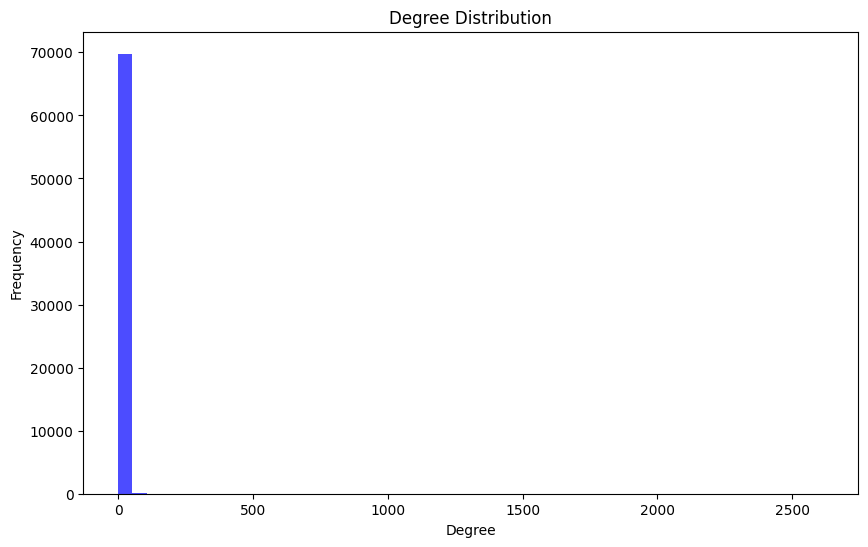

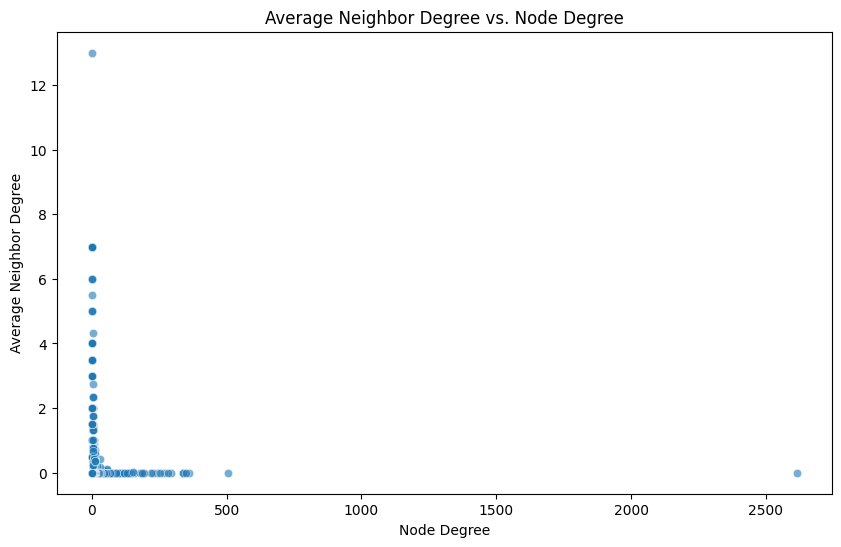

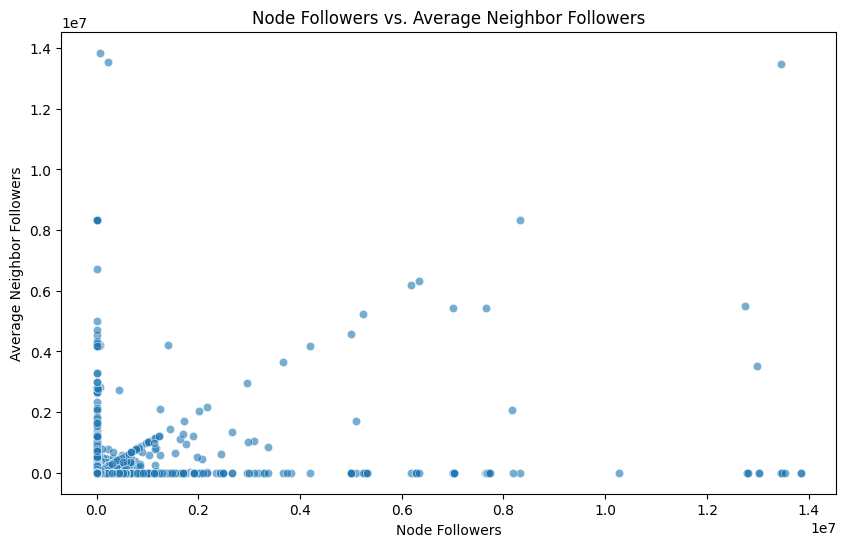

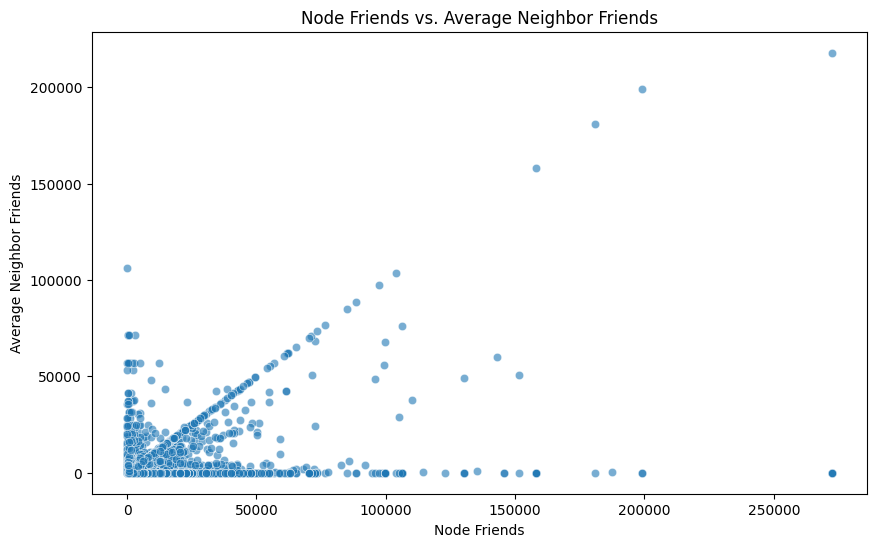

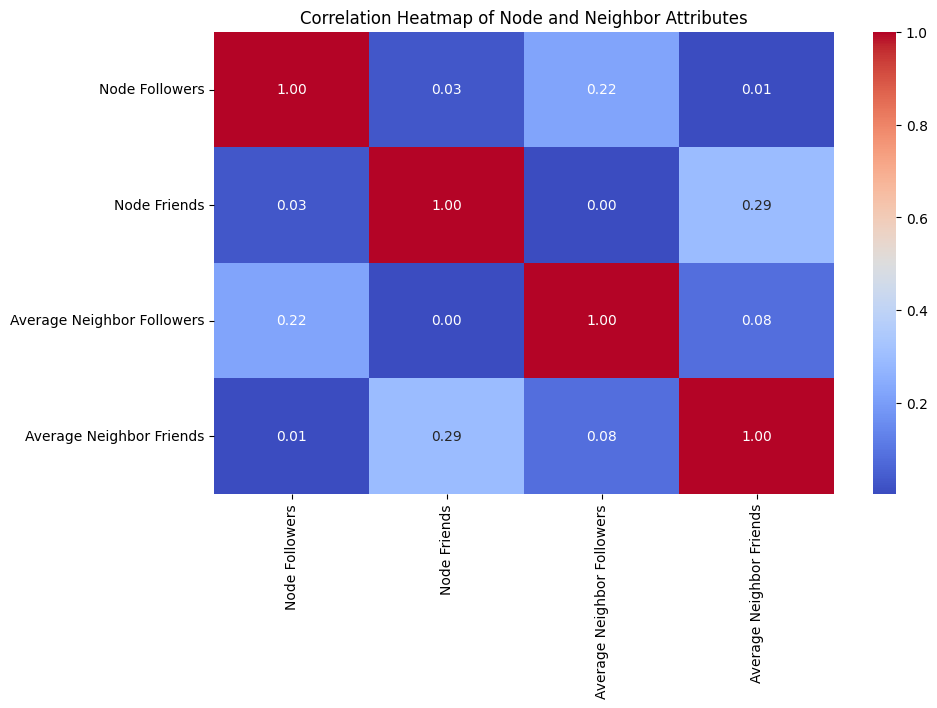

In [71]:
import seaborn as sns
# Degree Distribution
degrees = [G_mentions.degree(n) for n in G_mentions.nodes()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, color='blue', alpha=0.7)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

# Average Neighbor Degree vs. Node Degree
avg_neighbor_degree = nx.average_neighbor_degree(G_mentions)
node_degrees = dict(G_mentions.degree())

# Create a DataFrame for plotting
df_degree = pd.DataFrame({
    'Node Degree': list(node_degrees.values()),
    'Average Neighbor Degree': list(avg_neighbor_degree.values())
})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Node Degree', y='Average Neighbor Degree', data=df_degree, alpha=0.6)
plt.title('Average Neighbor Degree vs. Node Degree')
plt.xlabel('Node Degree')
plt.ylabel('Average Neighbor Degree')
plt.show()

# Scatter Plot of Node Attributes vs. Neighbor Attributes
def compute_avg_neighbor_attribute(graph, attribute):
    avg_neighbor_attr = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if neighbors:
            avg_neighbor_attr[node] = np.mean([graph.nodes[n].get(attribute, 0) for n in neighbors])
        else:
            avg_neighbor_attr[node] = 0
    return avg_neighbor_attr

# Compute average neighbor attributes
avg_neighbor_followers = compute_avg_neighbor_attribute(G_mentions, 'followers')
avg_neighbor_friends = compute_avg_neighbor_attribute(G_mentions, 'friends')

# Create DataFrames for plotting
df_followers = pd.DataFrame({
    'Node Followers': [G_mentions.nodes[n].get('followers', 0) for n in G_mentions.nodes()],
    'Average Neighbor Followers': list(avg_neighbor_followers.values())
})

df_friends = pd.DataFrame({
    'Node Friends': [G_mentions.nodes[n].get('friends', 0) for n in G_mentions.nodes()],
    'Average Neighbor Friends': list(avg_neighbor_friends.values())
})

# Plot for Followers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Node Followers', y='Average Neighbor Followers', data=df_followers, alpha=0.6)
plt.title('Node Followers vs. Average Neighbor Followers')
plt.xlabel('Node Followers')
plt.ylabel('Average Neighbor Followers')
plt.show()

# Plot for Friends
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Node Friends', y='Average Neighbor Friends', data=df_friends, alpha=0.6)
plt.title('Node Friends vs. Average Neighbor Friends')
plt.xlabel('Node Friends')
plt.ylabel('Average Neighbor Friends')
plt.show()

# Heatmap of Attribute Correlation
# Combine all attributes into a single DataFrame
df_attributes = pd.DataFrame({
    'Node Followers': [G_mentions.nodes[n].get('followers', 0) for n in G_mentions.nodes()],
    'Node Friends': [G_mentions.nodes[n].get('friends', 0) for n in G_mentions.nodes()],
    'Average Neighbor Followers': list(avg_neighbor_followers.values()),
    'Average Neighbor Friends': list(avg_neighbor_friends.values())
})

# Compute correlation matrix
corr_matrix = df_attributes.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Node and Neighbor Attributes')
plt.show()

In [72]:
import random

# Create a random version of the mention graph by rewiring edges
G_random = G_mentions.copy()

# Get a list of edges and shuffle it
edges = list(G_random.edges())
random.shuffle(edges)

# Rewire edges: randomly swap endpoints
num_edges = len(edges)
for _ in range(num_edges):  # Attempt a number of swaps
    u1, v1 = random.choice(edges)  # Pick a random edge
    u2, v2 = random.choice(edges)  # Pick another random edge

    # Ensure the selected edges exist before removing them
    if G_random.has_edge(u1, v1) and G_random.has_edge(u2, v2):
        # Ensure we don't create self-loops or duplicate edges
        if u1 != v2 and u2 != v1 and not G_random.has_edge(u1, v2) and not G_random.has_edge(u2, v1):
            G_random.remove_edge(u1, v1)
            G_random.remove_edge(u2, v2)
            G_random.add_edge(u1, v2)
            G_random.add_edge(u2, v1)

# Compute assortativity for the original and randomized network

random_followers_assort = nx.numeric_assortativity_coefficient(G_random, 'followers')
random_friends_assort = nx.numeric_assortativity_coefficient(G_random, 'friends')

# Print results
print(f"Randomized Assortativity for followers count: {random_followers_assort:.4f}")
print(f"Randomized Assortativity for friends count: {random_friends_assort:.4f}")


Randomized Assortativity for followers count: 0.2112
Randomized Assortativity for friends count: 0.2358


Assortativity (also called assortative mixing) measures how likely nodes with similar characteristics are to connect to each other. The values range from -1 to 1:

Close to 1 → Highly assortative (users prefer to interact with similar users).
Close to 0 → No preference (random interactions).
Close to -1 → Disassortative (users interact with very different users).
From our results:

The real Twitter mention network shows moderately high assortativity for followers (0.5064) and very high assortativity for friends (0.7472).
In contrast, the randomized network shows low assortativity (~0.22), meaning that any structured preferences disappeared when we shuffled the edges.

###**Visualization**

Plotting histograms of followers/friends counts for mentioned users vs. all users helps us understand the distribution of user influence and network structure.

🔹 How It Connects to Assortativity and Homophily
If the distributions are similar:

This suggests that mentions occur randomly, without a strong tendency toward mentioning users with similar characteristics.
This would indicate low assortativity (random interactions).
If the distributions are different:

Example: If the distribution for mentioned users is skewed toward higher follower counts, it means people preferentially mention high-follower accounts (celebrity bias).
If mentioned users have a similar distribution to the general population, it indicates homophily.

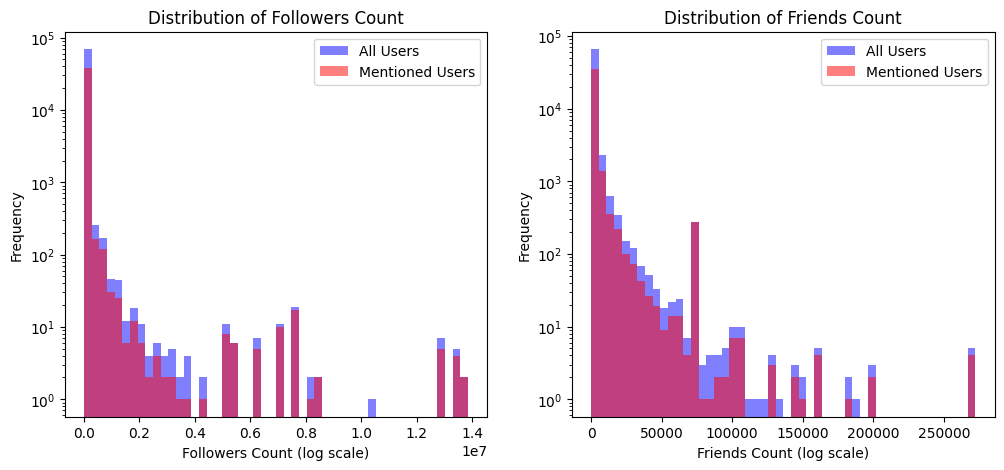

In [73]:
import matplotlib.pyplot as plt

# Extract followers and friends data for users in the mention network
followers_all = [data['followers'] for _, data in G_mentions.nodes(data=True) if 'followers' in data]
friends_all = [data['friends'] for _, data in G_mentions.nodes(data=True) if 'friends' in data]

# Extract followers/friends for only mentioned users
mentioned_users = set([edge[1] for edge in G_mentions.edges()])
followers_mentioned = [G_mentions.nodes[user]['followers'] for user in mentioned_users if 'followers' in G_mentions.nodes[user]]
friends_mentioned = [G_mentions.nodes[user]['friends'] for user in mentioned_users if 'friends' in G_mentions.nodes[user]]

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(followers_all, bins=50, alpha=0.5, label="All Users", log=True, color="blue")
plt.hist(followers_mentioned, bins=50, alpha=0.5, label="Mentioned Users", log=True, color="red")
plt.xlabel("Followers Count (log scale)")
plt.ylabel("Frequency")
plt.title("Distribution of Followers Count")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(friends_all, bins=50, alpha=0.5, label="All Users", log=True, color="blue")
plt.hist(friends_mentioned, bins=50, alpha=0.5, label="Mentioned Users", log=True, color="red")
plt.xlabel("Friends Count (log scale)")
plt.ylabel("Frequency")
plt.title("Distribution of Friends Count")
plt.legend()

plt.show()


 Scatter Plot of User Characteristics vs. Their Mentions
To visually understand assortativity, we can plot the number of followers (or friends) of a user versus the number of followers (or friends) of the users they mention. If there is a clear trend (e.g., a diagonal correlation), it indicates homophily (users mentioning those with similar characteristics).

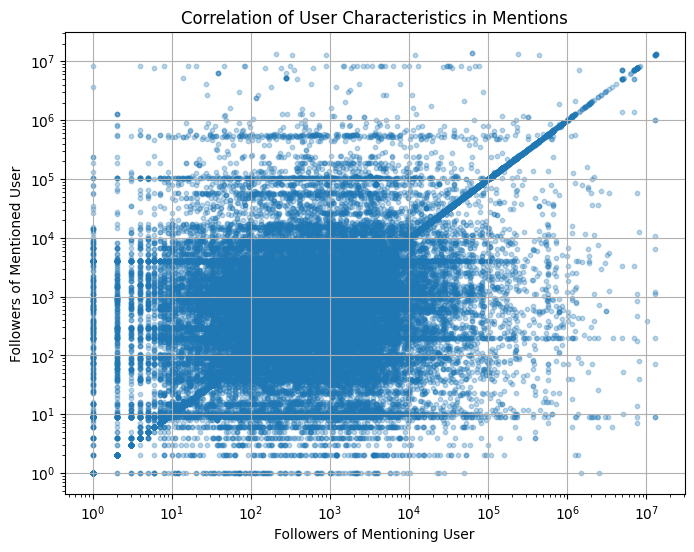

In [74]:
# Extract users and their characteristics from the graph
user_followers = {node: G_mentions.nodes[node]['followers'] for node in G_mentions.nodes() if 'followers' in G_mentions.nodes[node]}
mentioned_followers = []

for u, v in G_mentions.edges():
    if u in user_followers and v in user_followers:
        mentioned_followers.append((user_followers[u], user_followers[v]))

# Convert to scatter plot
x, y = zip(*mentioned_followers)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.3, s=10)
plt.xlabel("Followers of Mentioning User")
plt.ylabel("Followers of Mentioned User")
plt.title("Correlation of User Characteristics in Mentions")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

Assortativity Over Time

In [75]:
# Dictionary to store assortativity values over time
assortativity_over_time = defaultdict(lambda: {'followers': np.nan, 'friends': np.nan})

# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Iterate over unique time periods (e.g., daily)
unique_periods = sorted(df['year_month_day'].unique())

for period in tqdm(unique_periods, desc="Processing assortativity over time"):
    # Subset data for the time period
    df_period = df[df['year_month_day'] == period]

    # Create a temporary directed graph
    G_temp = nx.DiGraph()

    # Add edges based on mentions
    for _, row in df_period.iterrows():
        user1 = row['user_name']
        mentions = re.findall(r'@(\w+)', row['text'])
        for user2 in mentions:
            if user1 != user2:
                G_temp.add_edge(user1, user2)

    # Add attributes (followers, friends) to nodes
    for _, row in df_period.iterrows():
        user = row['user_name']
        if user in G_temp.nodes:
            G_temp.nodes[user]['followers'] = row['user_followers']
            G_temp.nodes[user]['friends'] = row['user_friends']

    # Ensure all nodes have the required attributes
    for node in G_temp.nodes:
        if 'followers' not in G_temp.nodes[node]:
            G_temp.nodes[node]['followers'] = 0  # Assign a default value
        if 'friends' not in G_temp.nodes[node]:
            G_temp.nodes[node]['friends'] = 0  # Assign a default value

    # Check if graph has enough edges for computation
    if G_temp.number_of_edges() > 0:
        unique_followers = set(nx.get_node_attributes(G_temp, 'followers').values())
        unique_friends = set(nx.get_node_attributes(G_temp, 'friends').values())

        if len(unique_followers) > 1 and len(unique_friends) > 1:
            followers_assort = nx.numeric_assortativity_coefficient(G_temp, 'followers')
            friends_assort = nx.numeric_assortativity_coefficient(G_temp, 'friends')
        else:
            followers_assort = np.nan
            friends_assort = np.nan
    else:
        followers_assort = np.nan
        friends_assort = np.nan

    # Store results
    assortativity_over_time[period]['followers'] = followers_assort
    assortativity_over_time[period]['friends'] = friends_assort

    # Debugging output
    print(f"Period: {period} - Nodes: {G_temp.number_of_nodes()}, Edges: {G_temp.number_of_edges()}")
    print(f"Unique Followers: {len(unique_followers)}, Unique Friends: {len(unique_friends)}")
    print(f"Followers Assortativity: {followers_assort}, Friends Assortativity: {friends_assort}\n")

print("Assortativity computation over time completed.")

# Convert periods to string format for plotting
time_periods = [str(period) for period in sorted(assortativity_over_time.keys())]
assort_followers = [assortativity_over_time[period]['followers'] for period in sorted(assortativity_over_time.keys())]
assort_friends = [assortativity_over_time[period]['friends'] for period in sorted(assortativity_over_time.keys())]


Processing assortativity over time:   4%|▍         | 1/26 [00:00<00:02,  9.06it/s]

Period: 2020-07-24 - Nodes: 240, Edges: 147
Unique Followers: 103, Unique Friends: 97
Followers Assortativity: nan, Friends Assortativity: nan



Processing assortativity over time:   8%|▊         | 2/26 [00:01<00:26,  1.11s/it]

Period: 2020-07-25 - Nodes: 8114, Edges: 6808
Unique Followers: 2123, Unique Friends: 1960
Followers Assortativity: -0.0029417634013160056, Friends Assortativity: -0.0024260465926309468



Processing assortativity over time:  12%|█▏        | 3/26 [00:02<00:20,  1.12it/s]

Period: 2020-07-26 - Nodes: 3756, Edges: 2931
Unique Followers: 1120, Unique Friends: 1122
Followers Assortativity: -0.005064746547215074, Friends Assortativity: -0.003839445911055335



Processing assortativity over time:  15%|█▌        | 4/26 [00:03<00:17,  1.26it/s]

Period: 2020-07-27 - Nodes: 3743, Edges: 2932
Unique Followers: 1167, Unique Friends: 1133
Followers Assortativity: -0.004721954140731843, Friends Assortativity: -0.00587571164978874



Processing assortativity over time:  19%|█▉        | 5/26 [00:03<00:16,  1.31it/s]

Period: 2020-07-28 - Nodes: 4143, Edges: 3506
Unique Followers: 1238, Unique Friends: 1219
Followers Assortativity: -0.0024395023544455286, Friends Assortativity: 0.008046078370680512



Processing assortativity over time:  23%|██▎       | 6/26 [00:04<00:11,  1.71it/s]

Period: 2020-07-29 - Nodes: 1910, Edges: 1449
Unique Followers: 700, Unique Friends: 704
Followers Assortativity: -0.0017612232586100155, Friends Assortativity: -0.00852419596527518



Processing assortativity over time:  27%|██▋       | 7/26 [00:04<00:10,  1.88it/s]

Period: 2020-07-30 - Nodes: 1418, Edges: 1062
Unique Followers: 569, Unique Friends: 571
Followers Assortativity: -0.0057808906559794785, Friends Assortativity: 0.004800605639215946



Processing assortativity over time:  31%|███       | 8/26 [00:05<00:11,  1.56it/s]

Period: 2020-07-31 - Nodes: 4602, Edges: 3533
Unique Followers: 1507, Unique Friends: 1425
Followers Assortativity: -0.0008384032709975787, Friends Assortativity: 0.00046099950626810006



Processing assortativity over time:  35%|███▍      | 9/26 [00:06<00:11,  1.45it/s]

Period: 2020-08-01 - Nodes: 4536, Edges: 3662
Unique Followers: 1356, Unique Friends: 1348
Followers Assortativity: -0.00227354963455371, Friends Assortativity: -0.011436286393251897



Processing assortativity over time:  38%|███▊      | 10/26 [00:07<00:11,  1.38it/s]

Period: 2020-08-02 - Nodes: 4515, Edges: 3745
Unique Followers: 1369, Unique Friends: 1353
Followers Assortativity: -0.002301814249276386, Friends Assortativity: 0.0677011780172866



Processing assortativity over time:  42%|████▏     | 11/26 [00:07<00:10,  1.40it/s]

Period: 2020-08-04 - Nodes: 3909, Edges: 3089
Unique Followers: 1234, Unique Friends: 1181
Followers Assortativity: -0.004797492488296127, Friends Assortativity: -0.0022646847482294093



Processing assortativity over time:  46%|████▌     | 12/26 [00:08<00:10,  1.34it/s]

Period: 2020-08-06 - Nodes: 4443, Edges: 3371
Unique Followers: 1455, Unique Friends: 1349
Followers Assortativity: -0.001713269286826512, Friends Assortativity: -0.008410956595358763

Period: 2020-08-07 - Nodes: 582, Edges: 389
Unique Followers: 232, Unique Friends: 238
Followers Assortativity: nan, Friends Assortativity: nan



Processing assortativity over time:  54%|█████▍    | 14/26 [00:09<00:07,  1.58it/s]

Period: 2020-08-08 - Nodes: 4509, Edges: 3629
Unique Followers: 1295, Unique Friends: 1243
Followers Assortativity: -0.0007613714713986697, Friends Assortativity: -0.015217721416919277



Processing assortativity over time:  58%|█████▊    | 15/26 [00:10<00:06,  1.59it/s]

Period: 2020-08-09 - Nodes: 3718, Edges: 3026
Unique Followers: 1106, Unique Friends: 1080
Followers Assortativity: -0.004731506613338738, Friends Assortativity: -0.003983344190782892



Processing assortativity over time:  62%|██████▏   | 16/26 [00:10<00:05,  1.72it/s]

Period: 2020-08-10 - Nodes: 3117, Edges: 2331
Unique Followers: 1032, Unique Friends: 1005
Followers Assortativity: -0.002139271034488122, Friends Assortativity: -0.004062958820082311



Processing assortativity over time:  65%|██████▌   | 17/26 [00:11<00:05,  1.68it/s]

Period: 2020-08-11 - Nodes: 3640, Edges: 2621
Unique Followers: 1219, Unique Friends: 1080
Followers Assortativity: -0.006518055982326128, Friends Assortativity: -0.012810353115788046



Processing assortativity over time:  69%|██████▉   | 18/26 [00:11<00:04,  1.67it/s]

Period: 2020-08-12 - Nodes: 3565, Edges: 2681
Unique Followers: 1129, Unique Friends: 1070
Followers Assortativity: -0.007104028321679107, Friends Assortativity: -0.011125541424835425



Processing assortativity over time:  73%|███████▎  | 19/26 [00:12<00:04,  1.62it/s]

Period: 2020-08-13 - Nodes: 3872, Edges: 2956
Unique Followers: 1228, Unique Friends: 1124
Followers Assortativity: -0.0026193611379395913, Friends Assortativity: 0.0028242723007318644



Processing assortativity over time:  77%|███████▋  | 20/26 [00:13<00:03,  1.59it/s]

Period: 2020-08-14 - Nodes: 4018, Edges: 3232
Unique Followers: 1216, Unique Friends: 1156
Followers Assortativity: -0.005801410909687406, Friends Assortativity: -0.0033616764576707286



Processing assortativity over time:  81%|████████  | 21/26 [00:14<00:03,  1.41it/s]

Period: 2020-08-16 - Nodes: 4176, Edges: 3464
Unique Followers: 1204, Unique Friends: 1185
Followers Assortativity: -0.005893585214963228, Friends Assortativity: -0.012685881263982724



Processing assortativity over time:  85%|████████▍ | 22/26 [00:14<00:02,  1.48it/s]

Period: 2020-08-17 - Nodes: 3730, Edges: 2888
Unique Followers: 1119, Unique Friends: 1077
Followers Assortativity: 0.006188809062379119, Friends Assortativity: -0.00026944483676678377



Processing assortativity over time:  88%|████████▊ | 23/26 [00:15<00:02,  1.37it/s]

Period: 2020-08-18 - Nodes: 4506, Edges: 3375
Unique Followers: 1524, Unique Friends: 1409
Followers Assortativity: -0.0025258863837978236, Friends Assortativity: 0.00458900358663818



Processing assortativity over time:  92%|█████████▏| 24/26 [00:16<00:01,  1.19it/s]

Period: 2020-08-22 - Nodes: 6074, Edges: 5033
Unique Followers: 1625, Unique Friends: 1560
Followers Assortativity: -0.003940228506314799, Friends Assortativity: -0.003068748503381949



Processing assortativity over time:  96%|█████████▌| 25/26 [00:16<00:00,  1.44it/s]

Period: 2020-08-29 - Nodes: 2691, Edges: 2205
Unique Followers: 849, Unique Friends: 836
Followers Assortativity: -0.002924824811897396, Friends Assortativity: -0.0054396604935775935



Processing assortativity over time: 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]

Period: 2020-08-30 - Nodes: 4662, Edges: 3945
Unique Followers: 1246, Unique Friends: 1228
Followers Assortativity: -0.0035656364810325108, Friends Assortativity: -0.007244076345733787

Assortativity computation over time completed.


In [76]:
assortativity_over_time

defaultdict(<function __main__.<lambda>()>,
            {Period('2020-07-24', 'D'): {'followers': nan, 'friends': nan},
             Period('2020-07-25', 'D'): {'followers': -0.0029417634013160056,
              'friends': -0.0024260465926309468},
             Period('2020-07-26', 'D'): {'followers': -0.005064746547215074,
              'friends': -0.003839445911055335},
             Period('2020-07-27', 'D'): {'followers': -0.004721954140731843,
              'friends': -0.00587571164978874},
             Period('2020-07-28', 'D'): {'followers': -0.0024395023544455286,
              'friends': 0.008046078370680512},
             Period('2020-07-29', 'D'): {'followers': -0.0017612232586100155,
              'friends': -0.00852419596527518},
             Period('2020-07-30', 'D'): {'followers': -0.0057808906559794785,
              'friends': 0.004800605639215946},
             Period('2020-07-31', 'D'): {'followers': -0.0008384032709975787,
              'friends': 0.000460999506268100

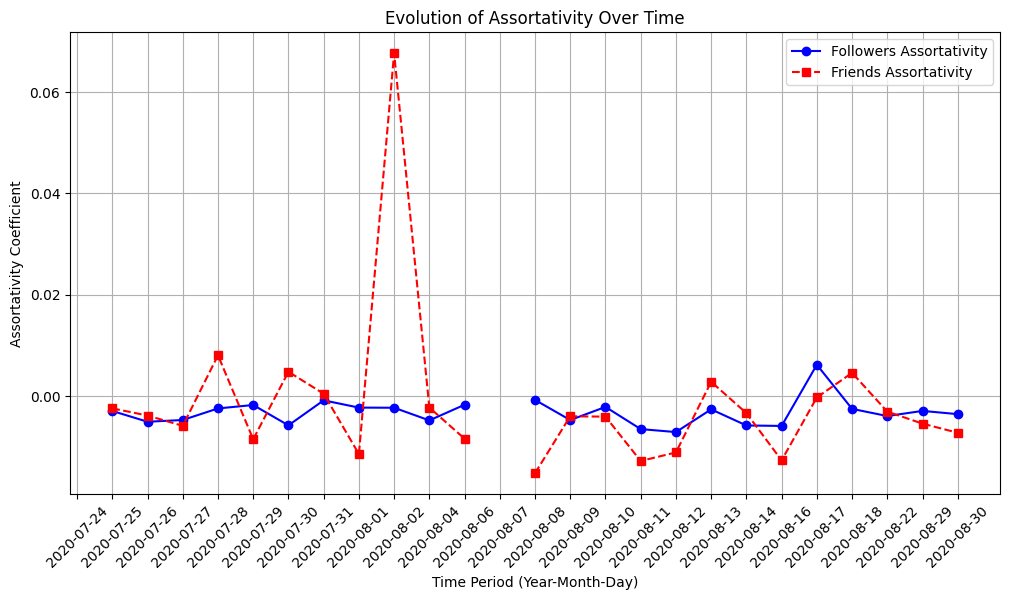

In [77]:
# Plot Assortativity Evolution for Followers and Friends
plt.figure(figsize=(12, 6))
plt.plot(time_periods, assort_followers, marker='o', linestyle='-', label="Followers Assortativity", color='blue')
plt.plot(time_periods, assort_friends, marker='s', linestyle='--', label="Friends Assortativity", color='red')
plt.xlabel("Time Period (Year-Month-Day)")
plt.ylabel("Assortativity Coefficient")
plt.title("Evolution of Assortativity Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


Low assortativity means that users are engaging across different audience sizes, making Twitter an open platform for discussions.
The spike in assortativity around August 1st could be analyzed further—checking the tweets on that day could reveal what event or trend caused this anomaly.
If the goal is to understand community formation, we can analyze specific subgraphs (e.g., influencers, active users, or political communities) separately to see if certain groups show stronger homophily.
The results suggest that mentions are not strongly driven by social status (follower count), meaning that discussions may be topic-driven rather than popularity-driven.


Sentiment and Opinion Analysis

Compute User Roles

We extract degree centrality and Louvian clustering to classify users.


In [78]:
import community.community_louvain as community

# Convert to Undirected Graph (Louvain works with undirected graphs)
G_undirected = G_mentions.to_undirected()

# pply Louvain Community Detection
partition = community.best_partition(G_undirected)

# Convert to DataFrame
df_louvain = pd.DataFrame(list(partition.items()), columns=['user_name', 'community'])

# Print the number of detected communities
num_communities = df_louvain['community'].nunique()
print(f"Detected {num_communities} communities.")

# Compute Degree Centrality
degree_centrality = nx.degree_centrality(G_undirected)

# Merge Louvain community info with centrality scores
df_louvain['degree_centrality'] = df_louvain['user_name'].map(degree_centrality)

# Identify Community Members (Users Belonging to Large Communities)
community_sizes = df_louvain['community'].value_counts()
large_communities = community_sizes[community_sizes > 10].index  # Filter out tiny communities

df_community_members = df_louvain[df_louvain['community'].isin(large_communities)]
community_members = set(df_community_members['user_name'])

print(f"Identified {len(community_members)} community members.")

# Identify Top Influencers in Each Community
top_influencers_per_community = df_louvain.sort_values(by=['community', 'degree_centrality'], ascending=[True, False])
top_influencers = top_influencers_per_community.groupby('community').head(1)  # Top 1 user per community

louvain_influencers = set(top_influencers['user_name'])  # Convert to set for fast lookup

print(f"Identified {len(louvain_influencers)} influencers within communities.")

# Compare Influencers Detected via Centrality vs. Louvain Clustering
common_influencers = influencers.intersection(louvain_influencers)

print(f"Overlap between centrality and Louvain influencers: {len(common_influencers)} users.")

Detected 10700 communities.
Identified 41931 community members.
Identified 10700 influencers within communities.


NameError: name 'influencers' is not defined

visualization of community sizes

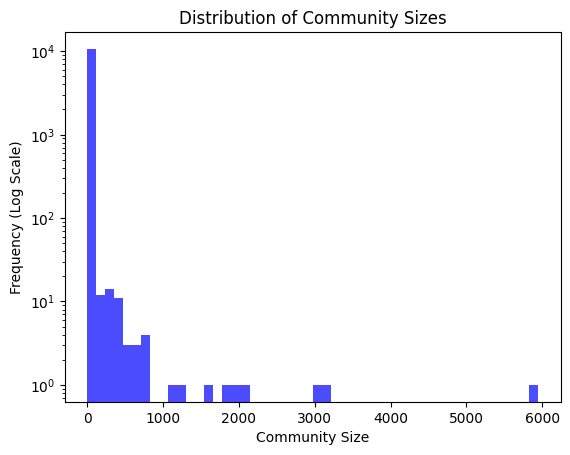

In [ ]:
import matplotlib.pyplot as plt

plt.hist(community_sizes, bins=50, log=True, color='blue', alpha=0.7)
plt.xlabel("Community Size")
plt.ylabel("Frequency (Log Scale)")
plt.title("Distribution of Community Sizes")
plt.show()

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Sentiment analysis with VADER

In [ ]:
analyzer = SentimentIntensityAnalyzer()

# Function to compute sentiment
def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']  # Overall sentiment score

# Apply sentiment analysis to each tweet
df['sentiment'] = df['text'].apply(get_sentiment)

# Check the distribution
df[['text', 'sentiment']].head()

,text,sentiment
17175,PROTESTORS NEEDED 6PM-10PM DAILY (NOW). 1450 E...,0.2500
17174,Always honored to speak w @NicolleDWallace abo...,0.3612
17173,"Excellent partnership to prevent #COVID19, tha...",0.7430
17172,Don't take your eye off the ball. There are st...,-0.2263
17171,"Apparently, at the Timberlea @saveonfoods stor...",-0.4466


In [ ]:
# Create a role mapping (influencers vs. community members)
df['role'] = 'other'
df.loc[df['user_name'].isin(louvain_influencers), 'role'] = 'influencer'
df.loc[df['user_name'].isin(community_members), 'role'] = 'community_member'

# Ensure the distribution is correct
df['role'].value_counts()

role
other               101451
community_member     59532
influencer           17700
Name: count, dtype: int64

Visualizing Sentiment Distribution

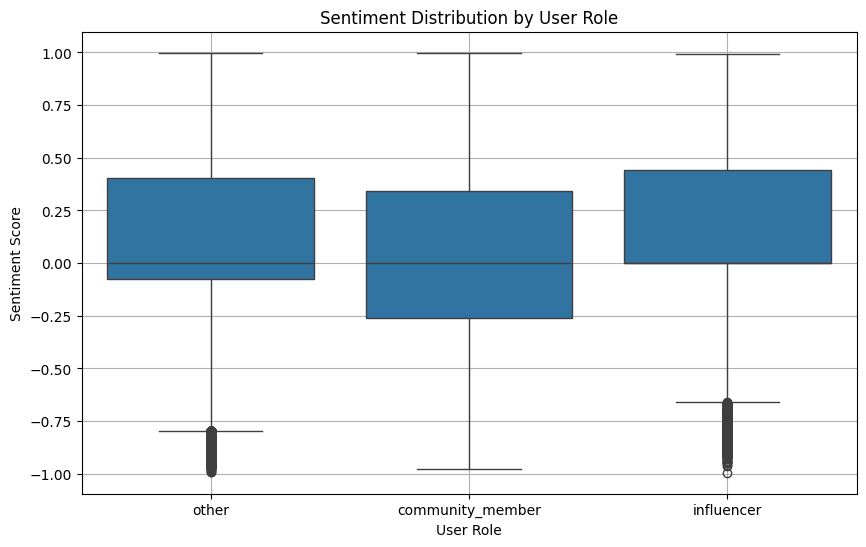

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['role'], y=df['sentiment'])
plt.xlabel("User Role")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Distribution by User Role")
plt.grid()
plt.show()

In [ ]:
df.groupby('role')['sentiment'].describe()

,count,mean,std,min,25%,50%,75%,max
role,,,,,,,,
community_member,59532.0,0.016830,0.411142,-0.9786,-0.25985,0.0,0.3400,0.9995
influencer,17700.0,0.117714,0.404363,-0.9952,0.00000,0.0,0.4404,0.9913
other,101451.0,0.075723,0.410888,-0.9914,-0.07720,0.0,0.4019,0.9986
